# Driving Towards a Brighter Future: EV Adoption Rates in California and its Effect on PM 2.5 Emissions (Part I)



This notebook is aimed at the exploratory data analysis for the growing presence of electric vehicles in California and its relationship with PM2.5 Emissions.

It consists of importing several datasets, cleaning and manipulating the data, merging the datasets together, and finally creating several visuals to help interpret the data. 

### Contributions: 
-  __Clarissa Clark__ - Data Import, Cleaning, and Merging (PM 2.5; Population Data)
- __Lucas Keller__ - Merged Visualizations (Heat Map, PM2.5 per Counties, t-test)
- __Brett Schmidt__ - Data Import, Cleaning, Vehicle Visualizations (California Vehicle), Correlation Plots
#### SIADS 593 Milestone I -  October 7th, 2024

# Imports and Requirements

In [1]:
# Set to true to install libraries as needed
def installrequirements(requirements=False):
    installopenpyxl = requirements
    installrequirements = requirements
    if installopenpyxl:
        !pip install openpyxl
    if installrequirements:
        !pip install -r requirements.txt
installrequirements(False)

In [2]:
## import required libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore, shapiro, spearmanr
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# California Vehicles - Import, Clean, and Visualization
Data sourced from https://www.energy.ca.gov/files/zev-and-infrastructure-stats-data and downloads as "Vehicle_Population_Last_updated_04-30-2024_ada.xlsx".

The dataset contains information on California vehicles, which includes registration year, county, make, model, fuel type, and total vehicles under those categories. 

The goal for this section is to import the data, remove unnecessary information, check for missing or unexpected values, and provide a dataframe to later merge on 'County' and 'Year'.

#### Import Data
Data is provided, but can be imported directly from the URL.

In [3]:
# File has been predownloaded and is part of the analysis package
vehicle_data = 'vehicle_data/california_vehicle.xlsx'

# Switch url_import if direct download is desired
url_import = False
if url_import:
    if not os.path.exists(vehicle_data_dir):
        os.makedirs(vehicle_data_dir)
    URL = 'https://www.energy.ca.gov/filebrowser/download/6311?fid=6311#block-symsoft-page-title'
    urlretrieve(URL, vehicle_data)

In [4]:
# Import data as a pandas dataframe
countyvehicle_df = pd.read_excel('vehicle_data/california_vehicle.xlsx',sheet_name="County")

#### Inspect and Reduce Data
We'll take a look at the shape, contents, and check for unnecessary columns.

In [5]:
# We've isolated the worksheet, now let's take a look at the shape and contents
print(countyvehicle_df.shape)
countyvehicle_df.head()

(33542, 7)


,Data Year,County,Dashboard Fuel Type Group,Fuel Type,Make,Model,Number of Vehicles
0,2010,Alameda,Battery Electric (BEV),Battery Electric (BEV),Ford,Ranger,3
1,2010,Alameda,Battery Electric (BEV),Battery Electric (BEV),Tesla,Roadster,17
2,2010,Alameda,Diesel,Diesel,NaN,NaN,10939
3,2010,Alameda,Gasoline,Flex Fuel,NaN,NaN,10974
4,2010,Alameda,Gasoline,Gasoline,NaN,NaN,840577


We see there are 33542 rows and 7 columns.
We're not interested in the Make or Model of the car, so let's drop those values and inspect the information of our dataframe.

In [6]:
countyvehicle_df = countyvehicle_df.drop(columns=['Make','Model'])
countyvehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33542 entries, 0 to 33541
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Data Year                  33542 non-null  int64 
 1   County                     33542 non-null  object
 2   Dashboard Fuel Type Group  33542 non-null  object
 3   Fuel Type                  33542 non-null  object
 4   Number of Vehicles         33542 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


There are __33542__ counts across each entry. That's good.

Now let's check for missing years and missing counties.

In [7]:
years = [year for year in countyvehicle_df['Data Year'].unique()]
actual_years = set(years)

expected_years = set(range(min(years), max(years) + 1))
missing_years = expected_years - actual_years

print(years)
print(f'\nData starts in {min(years)} and spans across {max(years)}')

if missing_years:
    print(f"Missing years: {missing_years}")
else:
    print("No missing years.")

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Data starts in 2010 and spans across 2023
No missing years.


In [8]:
# Get unique counties from the countyvehicle_df DataFrame
counties = [county for county in countyvehicle_df['County'].unique()]
actual_counties = set(counties)

# Define expected counties
expected_counties = set([
    "Alameda", "Alpine", "Amador", "Butte", "Calaveras", "Colusa",
    "Contra Costa", "Del Norte", "El Dorado", "Fresno", "Glenn",
    "Humboldt", "Imperial", "Inyo", "Kern", "Kings", "Lake",
    "Lassen", "Los Angeles", "Madera", "Marin", "Mariposa",
    "Mendocino", "Merced", "Modoc", "Mono", "Monterey", "Napa",
    "Nevada", "Orange", "Placer", "Plumas", "Riverside",
    "Sacramento", "San Benito", "San Bernardino", "San Diego",
    "San Francisco", "San Joaquin", "San Luis Obispo", "San Mateo",
    "Santa Barbara", "Santa Clara", "Santa Cruz", "Shasta",
    "Sierra", "Siskiyou", "Solano", "Sonoma", "Stanislaus",
    "Sutter", "Tehama", "Trinity", "Tulare", "Tuolumne",
    "Ventura", "Yolo", "Yuba"
])

# Find missing and unexpected counties
missing_counties = expected_counties - actual_counties
unexpected_counties = actual_counties - expected_counties

# Print results
if missing_counties:
    print(f"Missing counties: {missing_counties}")
else:
    print("No missing counties.")

if unexpected_counties:
    print(f"Unexpected counties: {unexpected_counties}")
else:
    print("No unexpected counties.")

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

No missing counties.
Unexpected counties: {'Out of State', 'Out Of State'}


There are unexpected counties that are from out of state.

Let's see what years have vehicles from out of state and how many there are.

We'll only look at the past 10 years for this analysis, but can be adjusted based on lookbackyears.

In [9]:
# Calculate total vehicles by year
vehicles_by_year = countyvehicle_df.groupby('Data Year')['Number of Vehicles'].sum()

lookback_years = 10  # Number of years to look back

# Iterate through the last 'lookback_years' unique years
for year in countyvehicle_df['Data Year'].unique()[-lookback_years:]:
    for unexpected_county in unexpected_counties:
        # Filter unexpected vehicles for the given year and county
        unexpected_vehicles = countyvehicle_df[
            (countyvehicle_df['Data Year'] == year) &
            (countyvehicle_df['County'] == unexpected_county)
        ]

        # Sum the number of unexpected vehicles
        total_unexpected_vehicles_by_year = unexpected_vehicles['Number of Vehicles'].sum()
        
        if total_unexpected_vehicles_by_year != 0:
            total_vehicles = vehicles_by_year.get(year, 0)
            ratio = (total_unexpected_vehicles_by_year / total_vehicles) * 100

            print(f"Percent of vehicles from '{unexpected_county}' in {year} is: {ratio:.2f}%")
            
#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

Percent of vehicles from 'Out Of State' in 2014 is: 2.13%
Percent of vehicles from 'Out Of State' in 2015 is: 2.11%
Percent of vehicles from 'Out Of State' in 2016 is: 1.64%
Percent of vehicles from 'Out Of State' in 2017 is: 1.58%
Percent of vehicles from 'Out Of State' in 2018 is: 1.51%
Percent of vehicles from 'Out Of State' in 2019 is: 1.69%
Percent of vehicles from 'Out Of State' in 2020 is: 1.55%
Percent of vehicles from 'Out of State' in 2021 is: 1.35%
Percent of vehicles from 'Out of State' in 2022 is: 1.40%
Percent of vehicles from 'Out Of State' in 2023 is: 1.37%


Looks like there are out of state vehicles present in our dataset for every year.

The non-california vehicles is ~1.3 - 2.1% of total vehicles across our entire data set.
We'll make the assumption that they won't impact our analysis and filter them out and check the shape.


In [10]:
calcountyvehicle_df = countyvehicle_df[~countyvehicle_df['County'].isin(unexpected_counties)]
calcountyvehicle_df.shape

(32763, 5)

#### Manipulation
Next, let's take a look at the fuel types that are used.
We're interested in impact of EVs and non-fossil fuel based cars.
There are two columns that cover the fuel type. 'Dashboard Fuel Type Group' and 'Fuel Type' that are fully populated (length 32763)
Let's take a look at the difference between the two.

In [11]:
fuel_types_1 = calcountyvehicle_df['Dashboard Fuel Type Group'].unique()
fuel_types_2 = calcountyvehicle_df['Fuel Type'].unique()

fuel_types_df = pd.DataFrame({
    'Fuel Type': pd.Series(fuel_types_2),
    'Dashboard Fuel Type Group': pd.Series(fuel_types_1)
})

fuel_types_df

,Fuel Type,Dashboard Fuel Type Group
0,Battery Electric (BEV),Battery Electric (BEV)
1,Diesel,Diesel
2,Flex Fuel,Gasoline
3,Gasoline,Gasoline Hybrid
4,Gasoline Hybrid,Other
5,Natural Gas,Fuel Cell (FCEV)
6,Propane,Plug-in Hybrid (PHEV)
7,Fuel Cell (FCEV),NaN
8,Plug-in Hybrid (PHEV),NaN


It appears Dashboard Fuel Type Group goes ahead and clusters them together. 
We're going to make our own cluster and group together vehicles based on fuel type.

Fossil Fuels will consist of:
- Diesel
- Flex Fuel
- Gasoline
- Gasoline Hybrid
- Natural Gas
- Propane

Electric Vehicles (EV) will consist of:
- Battery Electric
- Fuel Cell
- Plug-in Hybrid

We'll drop the necessary __'Dashboard Fuel Type Group'__ as well.

In [12]:
fossil_fuels = ['Diesel', 'Flex Fuel', 'Gasoline', 'Gasoline Hybrid', 'Natural Gas', 'Propane'] 
evs = ['Battery Electric (BEV)', 'Fuel Cell (FCEV)', 'Plug-in Hybrid (PHEV)']

def categorize_fuel(fuel_type):
    if fuel_type in fossil_fuels:
        return 'Fossil Fuel'
    elif fuel_type in evs:
        return 'EV'
    else:
        return 'Other'
    
calcountyvehicle_df.loc[:, ['Fuel Category']] = calcountyvehicle_df['Fuel Type'].apply(categorize_fuel)
calcountyvehicle_df = calcountyvehicle_df.drop(columns=['Dashboard Fuel Type Group'])

# Print the DataFrame to check the new column
calcountyvehicle_df.head()

,Data Year,County,Fuel Type,Number of Vehicles,Fuel Category
0,2010,Alameda,Battery Electric (BEV),3,EV
1,2010,Alameda,Battery Electric (BEV),17,EV
2,2010,Alameda,Diesel,10939,Fossil Fuel
3,2010,Alameda,Flex Fuel,10974,Fossil Fuel
4,2010,Alameda,Gasoline,840577,Fossil Fuel


Finally, we'll consolidate our dataframe based on __'County'__ and __'Fuel Category'__ and sum the __'Number of Vehicles'__ to provide the first dataframe for merging.

In [13]:
fueltype_per_countyyear_totals_df = (
    calcountyvehicle_df.groupby(['Data Year','County','Fuel Category'])['Number of Vehicles']
    .sum()
    .reset_index())

## Optional to export out as an excel file - uncomment next line ##
# vehicle_df.to_csv('vehicle_df', index = False)

print(fueltype_per_countyyear_totals_df.shape)
fueltype_per_countyyear_totals_df.head()


(1575, 4)


,Data Year,County,Fuel Category,Number of Vehicles
0,2010,Alameda,EV,20
1,2010,Alameda,Fossil Fuel,885402
2,2010,Alpine,Fossil Fuel,1041
3,2010,Amador,EV,1
4,2010,Amador,Fossil Fuel,30480


#### Visualization
Now, let's take a look at the trends of the vehicles!

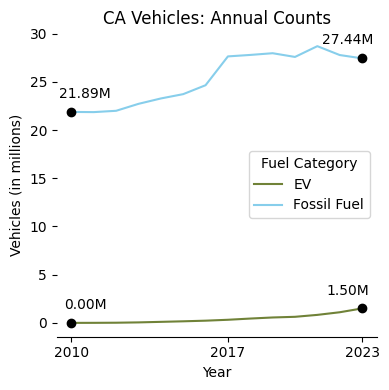

In [14]:
def yearly_vehicles_by_type(df):
    """
    Plots annual vehicle counts and growth rate by fuel category.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing 'Data Year', 'Fuel Category', and 'Number of Vehicles' columns.
    """

    # Group the data by 'Data Year' and 'Fuel Category', summing the number of vehicles
    grouped_df = df.groupby(['Data Year', 'Fuel Category'])['Number of Vehicles'].sum().reset_index()

    # Create a new column for the year-over-year growth rate
    grouped_df['Growth Rate'] = grouped_df.groupby('Fuel Category')['Number of Vehicles'].pct_change() * 100

    plt.figure(figsize=(4, 4))

    # Define colors for each fuel category
    color_mapping = {
        'EV': '#708238',  # Sage
        'Fossil Fuel': '#87CEEB'  # Sky blue
    }

    # Create a line plot for each fuel category
    for fuel in grouped_df['Fuel Category'].unique():
        fuel_group_df = grouped_df[grouped_df['Fuel Category'] == fuel]
        color = color_mapping.get(fuel)
        
        plt.plot(
            fuel_group_df['Data Year'], fuel_group_df['Number of Vehicles'] / 1_000_000,
            label=fuel, color=color
        )

        # Annotate the first and last points
        first_year = fuel_group_df.iloc[0]['Data Year']
        first_value = fuel_group_df.iloc[0]['Number of Vehicles'] / 1_000_000
        plt.annotate(
            f'{first_value:.2f}M',
            (first_year, first_value),
            textcoords="offset points", xytext=(10, 10), ha='center'
        )
        plt.plot(first_year, first_value, 'o', color='black')

        last_year = fuel_group_df.iloc[-1]['Data Year']
        last_value = fuel_group_df.iloc[-1]['Number of Vehicles'] / 1_000_000
        plt.annotate(
            f'{last_value:.2f}M',
            (last_year, last_value),
            textcoords="offset points", xytext=(-10, 10), ha='center'
        )
        plt.plot(last_year, last_value, 'o', color='black')

    # Set x-ticks for the first, middle, and last year
    years = grouped_df['Data Year'].unique()
    first_year = years[0]
    middle_year = years[len(years) // 2]  # Calculate the middle year
    last_year = years[-1]
    plt.xticks([first_year, middle_year, last_year], [first_year, middle_year, last_year])

    # Customize the plot's appearance
    plt.title('CA Vehicles: Annual Counts')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.ylabel("Vehicles (in millions)")
    plt.xlabel("Year")
    plt.legend(title='Fuel Category')

    # Optional: Save image to file
    save_img = False
    if save_img:
        plt.savefig("graphic_cali_vehicles_growth_rate.png", dpi=300)

    plt.tight_layout()
    plt.show()
#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

yearly_vehicles_by_type(fueltype_per_countyyear_totals_df)

There seems to be a steady growth of EVs and Fossil Fuel vehicles from 2010 to 2023. But - the total number of EVs went from a 0% market share in 2010 to a ~5% market share in 2023. That confirms our suspicion that EVs are being increasingly adopted. Let's visualize the growth rate of each category of vehicles.

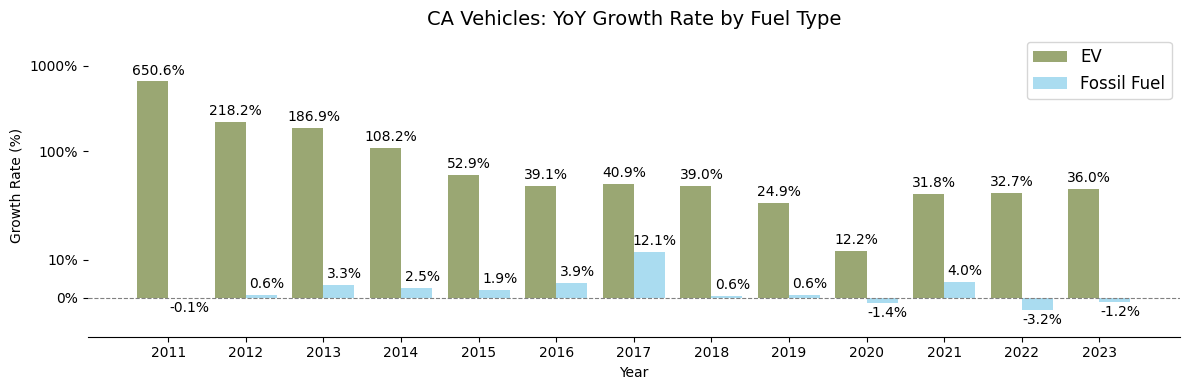

In [15]:
def percent_formatter(x, pos):
    # function to adjust y-scaling based on percentage growth
    return f'{int(x)}%'

def vehicleGrowthRate(df):
    """Calculate and plot the year-over-year growth rate of vehicles by fuel type."""
    
    #Group the data by 'Data Year' and 'Fuel Category', summing the number of vehicles
    grouped_df = df.groupby(['Data Year', 'Fuel Category'])['Number of Vehicles'].sum().reset_index()

    #Calculate the year-over-year growth rate and drop first year (.dropna)
    grouped_df['Growth Rate'] = grouped_df.groupby('Fuel Category')['Number of Vehicles'].pct_change() * 100
    grouped_df = grouped_df.dropna(subset=['Growth Rate'])

    #Plotting the growth rate as an overlapped bar graph
    plt.figure(figsize=(12, 4))
    bar_width = 0.4
    # sage and skyblue coloring
    color_mapping = {
            'EV': '#708238',      
            'Fossil Fuel': '#87CEEB'       
        }

    # Define x positions for the bars
    x = np.arange(len(grouped_df['Data Year'].unique()))
    years_with_data = grouped_df['Data Year'].unique()

    # Bar plot for growth rates with overlapping bars
    for i, fuel in enumerate(grouped_df['Fuel Category'].unique()):
        fuel_df = grouped_df[grouped_df['Fuel Category'] == fuel]

        color = color_mapping.get(fuel)

        # Using the index to plot bars at the same x position but different colors
        plt.bar(x + (i * bar_width), fuel_df['Growth Rate'], width=bar_width, label=fuel, alpha=0.7, color=color)

    # Set the x-ticks to show the years, split for number of fuel types
    number_of_fuel_types = len(grouped_df['Fuel Category'].unique())
    plt.xticks(x + (bar_width * (number_of_fuel_types - 1) / 2), years_with_data)

    # Annotate the bars with the growth rates
    for i, fuel in enumerate(grouped_df['Fuel Category'].unique()):

        # get df for particular fuel
        fuel_df = grouped_df[grouped_df['Fuel Category'] == fuel]

        # iterate through year (x position) and position the value (percentage) at the top of the bar, offset
        for j, value in enumerate(fuel_df['Growth Rate']):

            # Adjust xytext position depending on direction of bar (positive vs. negative)
            if value>=0:
                plt.annotate(f'{value:.1f}%', (x[j] + (i * bar_width), value), 
                             textcoords="offset points", xytext=(4, 5), ha='center')
            if value<0:
                plt.annotate(f'{value:.1f}%', (x[j] + (i * bar_width), value), 
                             textcoords="offset points", xytext=(4, -10), ha='center')
    # Title and Labels
    plt.ylabel("Growth Rate (%)")
    plt.xlabel("Year")
    
    plt.title('CA Vehicles: YoY Growth Rate by Fuel Type',fontsize=14)
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--') 

    # Set the y-axis to a logarithmic scaling and account for presence of negative values using 'sumlog'
    plt.yscale('symlog',linthresh=25)

    # Add exponential 25% buffer above the max growth rate
    max_growth = grouped_df['Growth Rate'].max()
    buffer_top = max_growth ** 1.2 

    # Keep the bottom close to zero but a little lower to see negative values
    buffer_bottom = -(abs(grouped_df['Growth Rate'].min()) ** 2) 

    # Set the y-limits and format them to show it as a percentage
    plt.ylim(buffer_bottom, buffer_top)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend(fontsize = 12)

    # optional logic to save image
    save_img = False
    if save_img:
        plt.savefig("graphic_caliVehiclesGrowthRate.png",dpi=300)


    # Show the plot
    plt.tight_layout()
    plt.show()
    
# cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

vehicleGrowthRate(fueltype_per_countyyear_totals_df)

EVs appear to have a stabilized year over year growth rate of ~30% whereas fossil fuel vehicles seem to have plateaued and may be trending downwards.

# PM 2.5 Emission by County - Import, Cleaning, and Manipulation
The United States Environmental Protection Agency requires counties to report daily air quality values. Annual datasets are publicly available at https://www.epa.gov/outdoor-air-quality-data/download-daily-data. Data from 2010 to 2024 was downloaded in the file 'pm_data'. 

Each dataset contains a plethora information including the date recorded, source name, site ID, daily mean PM2.5 concentration, concentration units, methodology, codes, county, site latitude and longitude. 

The goal is to filter and manipulate the dataframes to create a consolidated PM2.5 dataset that includes the year, county, average PM2.5 emissions per county, and the number of monitoring sites within each county. 

#### Import Data
Data is provided, but can be imported directly from the URL.

In [16]:
csv_2010 = 'pm_data/ad_viz_plotval_data_2010.csv'
csv_2011 = 'pm_data/ad_viz_plotval_data_2011.csv'
csv_2012 = 'pm_data/ad_viz_plotval_data_2012.csv'
csv_2013 = 'pm_data/ad_viz_plotval_data_2013.csv'
csv_2014 = 'pm_data/ad_viz_plotval_data_2014.csv'
csv_2015 = 'pm_data/ad_viz_plotval_data_2015.csv'
csv_2016 = 'pm_data/ad_vis_plotval_data_2016.csv'
csv_2017 = 'pm_data/ad_viz_plotval_data_2017.csv'
csv_2018 = 'pm_data/ad_viz_plotval_data2018.csv'
csv_2019 = 'pm_data/ad_viz_plotval_data2019.csv'
csv_2020 = 'pm_data/ad_viz_plotval_data2020.csv'
csv_2021 = 'pm_data/ad_viz_plotval_data2020.csv'
csv_2022 = 'pm_data/ad_viz_plotval_data2022.csv'
csv_2023 = 'pm_data/ad_viz_plotval_data2023.csv'
csv_2024 = 'pm_data/ad_viz_plotval_data2024.csv'

#### Inspect and Clean Data 
Evaluating the dataset and determining what can be cut out. 

In [17]:
# write function for initial data exploration
df = pd.read_csv(csv_2012)

print(df.shape)
df.columns

(44537, 22)


Index(['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM2.5 Concentration',
       'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count',
       'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description',
       'Method Code', 'Method Description', 'CBSA Code', 'CBSA Name',
       'State FIPS Code', 'State', 'County FIPS Code', 'County',
       'Site Latitude', 'Site Longitude'],
      dtype='object')

The columns that will be kept are: ['Date', 'Daily Mean PM2.5 Concentration','Units', 'Site ID', 'County', 'Site Latitude', 'Site Longitude']. From these, Data Year, Average PM 2.5/County, Number of Site IDs/County, County Latitude, and County Longitude can be determined to study the yearly average particulate matter present in each county.

In [18]:
def avg_pm_value(filename):
    """Process the CSV file and return a dataframe with average PM2.5 values 
    and geographical information for each county."""

    # Load data
    df = pd.read_csv(filename)

    # We are only concerned with the following columns
    df = df[['Date', 'Daily Mean PM2.5 Concentration', 'Units', 'Site ID', 
             'County', 'Site Latitude', 'Site Longitude']]

    # Change 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Add 'Data Year' column
    df['Data Year'] = df['Date'].dt.year

    # Determine the number of unique sites per county
    unique_sites_per_county = df.groupby('County')['Site ID'].nunique().reset_index()
    unique_sites_per_county.rename(columns={'Site ID': 'Number of Site IDs/County'}, inplace=True)

    # Calculate the average latitude and longitude per county
    average_latitude_county = df.groupby('County')['Site Latitude'].mean().round(2).reset_index()
    average_longitude_county = df.groupby('County')['Site Longitude'].mean().round(2).reset_index()

    # Merge latitude and longitude averages into one dataframe
    county_longitude_latitude = average_latitude_county.merge(average_longitude_county, on='County')
    county_longitude_latitude.rename(
        columns={'Site Latitude': 'County Latitude', 'Site Longitude': 'County Longitude'}, inplace=True
    )

    # Calculate average PM2.5 values per county per year
    avg_pm_value = df.groupby(['County', 'Data Year'])['Daily Mean PM2.5 Concentration'].mean().reset_index()
    avg_pm_value.rename(columns={'Daily Mean PM2.5 Concentration': 'Average PM 2.5/County'}, inplace=True)

    # Merge unique site counts, PM2.5 averages, and location data into a single dataframe
    merged_df = unique_sites_per_county.merge(avg_pm_value, on='County')
    final_df = merged_df.merge(county_longitude_latitude, on='County')

    # Pivot the table to organize the data per county
    final_df = final_df.pivot_table(
        index='County', 
        values=['Data Year', 'Average PM 2.5/County', 'Number of Site IDs/County', 
                'County Latitude', 'County Longitude']
    )

    # Reset the index
    final_df.reset_index(inplace=True)
    
    # function formatted for PEP 8 compliance through chat-gpt 10-7-2024
    
    return final_df

In [19]:
# Putting all file names through avg_pm_value function 
df_2010 = avg_pm_value(csv_2010)
df_2011 = avg_pm_value(csv_2011)
df_2012 = avg_pm_value(csv_2012)
df_2013 = avg_pm_value(csv_2013)
df_2014 = avg_pm_value(csv_2014)
df_2015 = avg_pm_value(csv_2015)
df_2016 = avg_pm_value(csv_2016) 
df_2017 = avg_pm_value(csv_2017)
df_2018 = avg_pm_value(csv_2018)
df_2019 = avg_pm_value(csv_2019)
df_2020 = avg_pm_value(csv_2020)
df_2021 = avg_pm_value(csv_2021)
df_2022 = avg_pm_value(csv_2022)
df_2023 = avg_pm_value(csv_2023)
df_2024 = avg_pm_value(csv_2024)

In [20]:
# Creating one dataframe by concatenating yearly data from 2010 to 2024
df_2010_2024 = pd.concat(
    [df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, 
     df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], 
    ignore_index=True, axis=0
)

# Converting 'Data Year' column to integer type
df_2010_2024['Data Year'] = df_2010_2024['Data Year'].astype(int)

# Selecting relevant columns
df_2010_2024 = df_2010_2024[
    ['Data Year', 'County', 'Average PM 2.5/County', 
     'Number of Site IDs/County', 'County Latitude', 'County Longitude']
]

# Renaming the dataset for clarity
df_pm = df_2010_2024

# Displaying the first few rows of the dataframe
df_pm.head()

# cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

,Data Year,County,Average PM 2.5/County,Number of Site IDs/County,County Latitude,County Longitude
0,2010,Alameda,8.165623,5,37.74,-122.10
1,2010,Butte,8.776451,3,39.50,-121.69
2,2010,Calaveras,7.380349,1,38.20,-120.68
3,2010,Colusa,6.054913,1,39.19,-122.00
4,2010,Contra Costa,7.606920,1,37.94,-122.03


# California Population - Import, Cleaning, and Manipulation 
We will use two population datasets: one detailing the total population per county, and another focusing on the population of individuals aged 18 and above per county. This allows us to compare the overall county populations with the potential number of car owners, as most individuals under 18 typically do not own a car.

### Total Population
From data on births, deaths, and migration, the State of California Department of Finances releases an estimate of the state's county population. 
Each dataset is organized by decade, and can be found at: https://dof.ca.gov/forecasting/demographics/estimates/. Data from 2010 to 2023 was downloaded as 
"E-4_2010-2020-Internet-Version.xlsx" and "E-4_2021_2024_InternetVersion (1).xlsx."

Each dateset contains each county's population estimate by year. 

Our goal for the datasets is to clean and merge them into a single dataframe that contains the population estimate by county during 2010-2023. 

#### Import Data
Each dataset had multiple sheets, but we were interested in the sheet that recorded the population by county ('Table 1 County State').

In [21]:
df_2010_2020 = pd.read_excel('./population_data/E-4_2010-2020-Internet-Version.xlsx', sheet_name= 'Table 1 County State')
df_2021_2023 = pd.read_excel('./population_data/E-4_2021_2024_InternetVersion (1).xlsx',sheet_name='Table 1 County State')

In [22]:
print(df_2010_2020.shape)
df_2010_2020.head()

(60, 15)


,Table 1: E-4 Population Estimates for Counties and State 2011-2020 with 2010 Benchmark,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,COUNTY,4/1/2010,1/1/2011,1/1/2012,1/1/2013,1/1/2014,1/1/2015,1/1/2016,1/1/2017,1/1/2018,1/1/2019,1/1/2020,4/1/2020,Column1,Column2
1,Alameda,1510271,1527169,1549193,1575139,1597747,1622205,1641983,1656919,1666247,1675964,1681337,1682353,NaN,NaN
2,Alpine,1175,1174,1176,1180,1185,1190,1196,1201,1205,1201,1204,1204,NaN,NaN
3,Amador,38091,37089,37272,37044,37089,37453,37663,38807,39708,40227,40426,40474,NaN,NaN
4,Butte,220000,221377,222623,224391,225737,227400,228198,230412,231774,227263,216090,211632,NaN,NaN


In [23]:
print(df_2021_2023.shape)
df_2021_2023.head()

(61, 6)


,About the Data,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Table 1: E-4 Population Estimates for Counties...,NaN,NaN,NaN,NaN,NaN
1,COUNTY,4/1/2020,1/1/2021,1/1/2022,1/1/2023,1/1/2024
2,Alameda,1682353,1666341,1643683,1650656,1641869
3,Alpine,1204,1195,1190,1183,1179
4,Amador,40474,40047,40010,39924,39611


#### Format data 
As it stands, each dataset will not be able to merge with df_pm or df_vehicles. 
Let's clean up df_2010_2020 first.

In [24]:
 # Renaming unnamed columns to correlated year
mapping = {
    'Table 1: E-4 Population Estimates for Counties and State 2011-2020 with 2010 Benchmark': 'County',
    'Unnamed: 1': '2010',
    'Unnamed: 2': '2011',
    'Unnamed: 3': '2012',
    'Unnamed: 4': '2013',
    'Unnamed: 5': '2014',
    'Unnamed: 6': '2015',
    'Unnamed: 7': '2016',
    'Unnamed: 8': '2017',
    'Unnamed: 9': '2018',
    'Unnamed: 10': '2019',
    'Unnamed: 11': '2020'
}
df_2010_2020.rename(columns=mapping, inplace=True)

# Removing Unnessary Columns 
df_2010_2020 = df_2010_2020.drop(columns=['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'])

# Removing 'State Total' from 'County' and redundant row
df_2010_2020 = df_2010_2020[~df_2010_2020['County'].isin(['State Total', 'COUNTY'])]
df_2010_2020.reset_index(drop=True, inplace=True)
df_2010_2020.head()

,County,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Alameda,1510271,1527169,1549193,1575139,1597747,1622205,1641983,1656919,1666247,1675964,1681337
1,Alpine,1175,1174,1176,1180,1185,1190,1196,1201,1205,1201,1204
2,Amador,38091,37089,37272,37044,37089,37453,37663,38807,39708,40227,40426
3,Butte,220000,221377,222623,224391,225737,227400,228198,230412,231774,227263,216090
4,Calaveras,45578,45561,45544,45499,45461,45395,45402,45355,45367,45324,45290


In [25]:
# Now let's clean up the second dataset 
# renaming unnamed columns to correlated year
mapping_2 = {
    'About the Data': 'County',
    'Unnamed: 2': '2021',
    'Unnamed: 3': '2022',
    'Unnamed: 4': '2023',
    'Unnamed: 5': '2024'
}
df_2021_2023.rename(columns=mapping_2, inplace=True)
df_2021_2023 = df_2021_2023.drop(columns=['Unnamed: 1'])
# Removing 'State Total' from 'County' and redundant rows
df_2021_2023 = df_2021_2023[~df_2021_2023['County'].isin(['State Total', 'COUNTY', 'Table 1: E-4 Population Estimates for Counties and State 2021-2024 with 2020 Benchmark'])]
df_2021_2023.reset_index(drop=True, inplace=True)
df_2021_2023.head()

,County,2021,2022,2023,2024
0,Alameda,1666341,1643683,1650656,1641869
1,Alpine,1195,1190,1183,1179
2,Amador,40047,40010,39924,39611
3,Butte,207403,206184,206579,205928
4,Calaveras,45259,45021,44899,44842


Now that they look a little more readable, we will merge the datasets into one. 

In [26]:
total_pop_df = pd.merge(df_2010_2020, df_2021_2023, on=['County'], how='outer')
total_pop_df.head()

,County,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Alameda,1510271,1527169,1549193,1575139,1597747,1622205,1641983,1656919,1666247,1675964,1681337,1666341,1643683,1650656,1641869
1,Alpine,1175,1174,1176,1180,1185,1190,1196,1201,1205,1201,1204,1195,1190,1183,1179
2,Amador,38091,37089,37272,37044,37089,37453,37663,38807,39708,40227,40426,40047,40010,39924,39611
3,Butte,220000,221377,222623,224391,225737,227400,228198,230412,231774,227263,216090,207403,206184,206579,205928
4,Calaveras,45578,45561,45544,45499,45461,45395,45402,45355,45367,45324,45290,45259,45021,44899,44842


We'll pivot table so that the years also form a column, just like df_vehicles and df_pm. 

In [27]:
df_pop = pd.melt(total_pop_df, id_vars=['County'], var_name='Year', value_name='Population')
df_pop['Year'] = df_pop['Year'].str.replace(":", "", regex=False)
df_pop.rename(columns={'Year': 'Data Year'}, inplace=True) 
# converting the 'Population' column to numeric 
df_pop['Population'] = pd.to_numeric(df_pop['Population'], errors='coerce')
# calculating the Z-score for the 'Population' column
df_pop['Population Z Score'] = zscore(df_pop['Population'])
# formatting Data Year to integer  
df_pop['Data Year'] = df_pop['Data Year'].astype(int)
df_pop.head()

,County,Data Year,Population,Population Z Score
0,Alameda,2010,1510271,0.585020
1,Alpine,2010,1175,-0.463909
2,Amador,2010,38091,-0.438250
3,Butte,2010,220000,-0.311810
4,Calaveras,2010,45578,-0.433046


### Adult Population 
Most car owners are adults, aged 18 years and above. By comparing car adoption rates to the population of possible car owners, we can give our analysis more precision. 

The United States Census Bureau releases annual reports on population by demographics, such as age and race. Datasets can be filtered by area, year, and desired demographic at https://data.census.gov/table/ACSST5Y2020.S0101?g=040XX00US06,06$0500000. Data from 2010 to 2023 was downloaded in the format of 'Pop_Over_18_Year.csv' in the file population_data. 

Our goal for these datasets was to merge them into one dataframe that included the Data Year, County, and Adult Population Estimate. 

#### Import Data 
Data is provided, but can be gathered from the URL. 

In [28]:
adult_csv_2010 = pd.read_csv('population_data/Pop_Over_18_2010.csv')
adult_csv_2011 = pd.read_csv('population_data/Pop_Over_18_2011.csv')
adult_csv_2012 = pd.read_csv('population_data/Pop_Over_18_2012.csv')
adult_csv_2013 = pd.read_csv('population_data/Pop_Over_18_2013.csv')
adult_csv_2014 = pd.read_csv('population_data/Pop_Over_18_2014.csv')
adult_csv_2015 = pd.read_csv('population_data/Pop_Over_18_2015.csv')
adult_csv_2016 = pd.read_csv('population_data/Pop_Over_18_2016.csv')
adult_csv_2017 = pd.read_csv('population_data/Pop_Over_18_2017.csv')
adult_csv_2018 = pd.read_csv('population_data/Pop_Over_18_2018.csv')
adult_csv_2019 = pd.read_csv('population_data/Pop_Over_18_2019.csv')
adult_csv_2020 = pd.read_csv('population_data/pop_over_18_2020.csv')
adult_csv_2021 = pd.read_csv('population_data/Pop_Over_18_2021.csv')
adult_csv_2022 = pd.read_csv('population_data/Pop_Over_18_2022.csv')
adult_csv_2023 = pd.read_csv('population_data/Pop_Over_18_2023.csv')

In [29]:
print(adult_csv_2010.shape)
adult_csv_2010.head()

(40, 247)


,Label (Grouping),California!!Total!!Estimate,California!!Total!!Margin of Error,California!!Male!!Estimate,California!!Male!!Margin of Error,California!!Female!!Estimate,California!!Female!!Margin of Error,"Alameda County, California!!Total!!Estimate","Alameda County, California!!Total!!Margin of Error","Alameda County, California!!Male!!Estimate",...,"Yolo County, California!!Male!!Estimate","Yolo County, California!!Male!!Margin of Error","Yolo County, California!!Female!!Estimate","Yolo County, California!!Female!!Margin of Error","Yuba County, California!!Total!!Estimate","Yuba County, California!!Total!!Margin of Error","Yuba County, California!!Male!!Estimate","Yuba County, California!!Male!!Margin of Error","Yuba County, California!!Female!!Estimate","Yuba County, California!!Female!!Margin of Error"
0,Total population,"37,349,363",*****,"18,570,505","±5,032","18,778,858","±5,032","1,513,952",*****,"742,561",...,"97,884",±637,"103,306",±637,"72,388",*****,"36,883","±1,150","35,505","±1,150"
1,AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Under 5 years,6.8%,±0.1,7.0%,±0.1,6.6%,±0.1,6.4%,±0.1,6.7%,...,6.4%,±0.2,6.0%,±0.2,8.2%,±0.3,8.4%,±1.2,8.1%,±1.0
3,5 to 9 years,6.8%,±0.1,6.9%,±0.1,6.7%,±0.1,6.3%,±0.2,6.4%,...,6.3%,±1.1,6.7%,±0.9,8.0%,±1.3,6.9%,±2.3,9.1%,±1.9
4,10 to 14 years,6.9%,±0.1,7.2%,±0.1,6.7%,±0.1,6.0%,±0.2,6.4%,...,6.7%,±1.1,5.1%,±0.9,8.0%,±1.2,8.8%,±2.4,7.2%,±1.9


In [30]:
print(adult_csv_2017.shape)
adult_csv_2017.head()

(42, 493)


,Label (Grouping),California!!Total!!Estimate,California!!Total!!Margin of Error,California!!Percent!!Estimate,California!!Percent!!Margin of Error,California!!Male!!Estimate,California!!Male!!Margin of Error,California!!Percent Male!!Estimate,California!!Percent Male!!Margin of Error,California!!Female!!Estimate,...,"Yuba County, California!!Percent!!Estimate","Yuba County, California!!Percent!!Margin of Error","Yuba County, California!!Male!!Estimate","Yuba County, California!!Male!!Margin of Error","Yuba County, California!!Percent Male!!Estimate","Yuba County, California!!Percent Male!!Margin of Error","Yuba County, California!!Female!!Estimate","Yuba County, California!!Female!!Margin of Error","Yuba County, California!!Percent Female!!Estimate","Yuba County, California!!Percent Female!!Margin of Error"
0,Total population,"39,536,653",*****,(X),(X),"19,650,051","±4,631",(X),(X),"19,886,602",...,(X),(X),"39,729",±907,(X),(X),"37,302",±907,(X),(X)
1,AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Under 5 years,"2,460,425","±3,179",6.2%,±0.1,"1,259,243","±2,975",6.4%,±0.1,"1,201,182",...,7.8%,±0.6,"2,628",±466,6.6%,±1.1,"3,353",±558,9.0%,±1.4
3,5 to 9 years,"2,468,508","±19,146",6.2%,±0.1,"1,268,641","±13,847",6.5%,±0.1,"1,199,867",...,8.4%,±1.1,"2,726",±593,6.9%,±1.5,"3,770",±688,10.1%,±1.8
4,10 to 14 years,"2,597,863","±19,413",6.6%,±0.1,"1,319,558","±14,022",6.7%,±0.1,"1,278,305",...,7.3%,±1.1,"3,695",±806,9.3%,±2.0,"1,944",±569,5.2%,±1.5


#### Format Data 
In 2017, the US Census Bureau changed their population reports from percentages to whole numbers. Although this created a better format for future generations, it maks our job a bit more difficult because we only want whole numbers. The following function pulls out the 2010-2016 population from the 2017-2023 population, selects the desired columns, and maps county names to corresponding columns. 

In [31]:
# Function to extract population percentage (for ages 18+) due to changes from 2017 onward
def aged_population2(dataset, datayear):
    """Extracts the percentage of the population aged 18+ for California counties.
    
    Adjusts the columns of interest depending on the year, as the population percentage
    format changed in 2017.
    
    Args:
        dataset (str): The file path to the dataset (CSV file).
        datayear (int): The year of the dataset (used to adjust column selection).
        
    Returns:
        DataFrame: A dataframe containing the population percentage for ages 18+.
    """

    if datayear > 2016:
        df = pd.read_csv(dataset)
        
        # Select columns relevant to population percentages for 18+ years (2017 onward)
        columns_of_interest = [
            column for column in df.columns 
            if "County, California!!Percent!!Estimate" in column
        ]
        
        # Filter rows containing "18 years and over"
        row_18_years_and_over = df[df.iloc[:, 0].str.contains("18 years and over", na=False)]
        row_18_years_and_over = row_18_years_and_over[columns_of_interest]
        
        # Rename columns for clarity
        column_mapping = {column: column.split(" County")[0] for column in columns_of_interest}
        row_18_years_and_over.rename(columns=column_mapping, inplace=True)

    elif datayear > 2009:
        df = pd.read_csv(dataset)
        
        # Select columns relevant to population totals for 18+ years (2010-2016)
        columns_of_interest = [
            column for column in df.columns 
            if "County, California!!Total!!Estimate" in column
        ]
        
        # Filter rows containing "18 years and over"
        row_18_years_and_over = df[df.iloc[:, 0].str.contains("18 years and over", na=False)]
        row_18_years_and_over = row_18_years_and_over[columns_of_interest]
        
        # Rename columns for clarity
        column_mapping = {column: column.split(" County")[0] for column in columns_of_interest}
        row_18_years_and_over.rename(columns=column_mapping, inplace=True)

    else:
        row_18_years_and_over = []
    
    # function formatted for PEP 8 compliance using chat-gpt 10-7-2024
    
    return row_18_years_and_over

In [32]:
# run function with dataset files and the corresponding year. 
totpop2010 = aged_population2('population_data/Pop_Over_18_2010.csv', 2010)
totpop2011 = aged_population2('population_data/Pop_Over_18_2011.csv', 2011)
totpop2012 = aged_population2('population_data/Pop_Over_18_2012.csv', 2012)
totpop2013 = aged_population2('population_data/Pop_Over_18_2013.csv', 2013)
totpop2014 = aged_population2('population_data/Pop_Over_18_2014.csv', 2014)
totpop2015 = aged_population2('population_data/Pop_Over_18_2015.csv', 2015)
totpop2016 = aged_population2('population_data/Pop_Over_18_2016.csv', 2016)
totpop2017 = aged_population2('population_data/Pop_Over_18_2017.csv', 2017)
totpop2018 = aged_population2('population_data/Pop_Over_18_2018.csv', 2018)
totpop2019 = aged_population2('population_data/Pop_Over_18_2019.csv', 2019)
totpop2020 = aged_population2('population_data/Pop_Over_18_2020.csv', 2020)
totpop2021 = aged_population2('population_data/Pop_Over_18_2021.csv', 2021)
totpop2022 = aged_population2('population_data/Pop_Over_18_2022.csv', 2022)
totpop2023 = aged_population2('population_data/Pop_Over_18_2023.csv', 2023)

Now that we have the data seperated into percentages and whole numbers, we will shape it to be mergeable on df[['Data Year', 'County']] 

In [33]:
# Create an empty list to hold dataframes for each year
totalpop = []

# Loop through each year from 2010 to 2024
for year in range(2010, 2024):
    # Read in the population data for the given year
    df_year = aged_population2(f'population_data/Pop_Over_18_{year}.csv', year)
    
    # Add the 'Data Year' column
    df_year['Data Year'] = year
    
    # Append the dataframe to the totalpop list
    totalpop.append(df_year)

# Concatenate all the yearly dataframes, stacking them on top of each other
df_aged_unshaped = pd.concat(totalpop, ignore_index=True)

# Add the remaining columns, making sure 'Data Year' is the first column
cols = ['Data Year'] + [col for col in df_aged_unshaped.columns if col != 'Data Year']
df_aged_unshaped = df_aged_unshaped[cols]

# Arrange dataframe by 'Data Year'
df_aged_unshaped.set_index('Data Year')

# Ensure the remaining columns are all counties
county_cols = [col for col in df_aged_unshaped.columns if col != 'Data Year']

# Define function to reshape population data
def reshape_population_data(df):
    """Reshape population data from wide to long format."""
    
    # Ensure the 'Data Year' column is of integer type
    df['Data Year'] = df['Data Year'].astype(int)
    
    # Use melt to convert county columns into rows
    melted_df = df.melt(
        id_vars=['Data Year'], 
        var_name='County', 
        value_name='Population Percentage >18'
    )
    
    # Drop rows where 'Population Percentage >18' is NaN
    melted_df.dropna(subset=['Population Percentage >18'], inplace=True)
    
    # Reset the index for a clean dataframe
    melted_df.reset_index(drop=True, inplace=True)
    
    return melted_df

# Run concatenated data through reshape_population_data
df_adult_pop = reshape_population_data(df_aged_unshaped)

# Show the first few rows of the reshaped dataframe
df_adult_pop.head()

# cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

,Data Year,County,Population Percentage >18
0,2010,Alameda,77.5%
1,2011,Alameda,77.7%
2,2012,Alameda,77.9%
3,2013,Alameda,78.3%
4,2014,Alameda,78.6%


Notice how now all of df_aged_pop['Population Estimate, >18'] is in percentage form while pop_df['Population'] is in whole number form. We will manage this discrepancy when we merge it with the rest of the data. 

# Creating main_df

#### Manipulating fueltype_per_countyyear_totals_df for analysis
By separating fueltype_per_countyyear_totals_df into two columns, Number of EVs and Number of Gas Cars, a more direct comparison between counties by year can be made .

In [34]:
fueltype_per_countyyear_totals_df.head()

,Data Year,County,Fuel Category,Number of Vehicles
0,2010,Alameda,EV,20
1,2010,Alameda,Fossil Fuel,885402
2,2010,Alpine,Fossil Fuel,1041
3,2010,Amador,EV,1
4,2010,Amador,Fossil Fuel,30480


In [35]:
# Creating 'Number of EVs' column from fueltype_per_countyyear_totals_df
df_ev_vehicles = fueltype_per_countyyear_totals_df[
    fueltype_per_countyyear_totals_df['Fuel Category'] == 'EV'
]

# Renaming 'Number of Vehicles' column to 'Number of EV'
df_ev_vehicles = df_ev_vehicles.rename(columns={'Number of Vehicles': 'Number of EV'})

# Dropping the 'Fuel Category' column
df_ev_vehicles = df_ev_vehicles.drop(columns=['Fuel Category'])

# Resetting the index for a clean dataframe
df_ev_vehicles = df_ev_vehicles.reset_index(drop=True)

# Display the first few rows of the dataframe
df_ev_vehicles.head()

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

,Data Year,County,Number of EV
0,2010,Alameda,20
1,2010,Amador,1
2,2010,Contra Costa,10
3,2010,Fresno,2
4,2010,Humboldt,2


In [36]:
# Creating 'Number of Gas Cars' column from fueltype_per_countyyear_totals_df
df_gas_vehicles = fueltype_per_countyyear_totals_df[
    fueltype_per_countyyear_totals_df['Fuel Category'] == 'Fossil Fuel'
]

# Renaming 'Number of Vehicles' column to 'Number of Gas Cars'
df_gas_vehicles = df_gas_vehicles.rename(columns={'Number of Vehicles': 'Number of Gas Cars'})

# Dropping the 'Fuel Category' column
df_gas_vehicles = df_gas_vehicles.drop(columns=['Fuel Category'])

# Resetting the index for a clean dataframe
df_gas_vehicles = df_gas_vehicles.reset_index(drop=True)

# Display the first few rows of the dataframe
df_gas_vehicles.head()

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

,Data Year,County,Number of Gas Cars
0,2010,Alameda,885402
1,2010,Alpine,1041
2,2010,Amador,30480
3,2010,Butte,133169
4,2010,Calaveras,39636


Theoretically, each of the vehicle dataframes should be the same shape. 

In [37]:
print(f'EV Vehicle shape is: {df_ev_vehicles.shape}')
print(f'Gas vehicle shape is: {df_gas_vehicles.shape}')

EV Vehicle shape is: (763, 3)
Gas vehicle shape is: (812, 3)


They are not. On closer inspection of the dataframes, we see that df_ev_vehicles only contains counties that have registered electric vehicles and some counties do not. Since gas cars are more prevalent, df_gas_vehicles has an entry for each column. We can fix this discrepancy by doing an outer merge and replacing the consequent NaNs with zeros. 

In [38]:
# Merging gas and EV vehicle data on 'Data Year' and 'County'
df_vehicles = pd.merge(
    df_gas_vehicles, 
    df_ev_vehicles, 
    on=['Data Year', 'County'], 
    how='outer'
)

# Filling missing values in 'Number of EV' with 0 and converting to integer type
df_vehicles['Number of EV'] = df_vehicles['Number of EV'].fillna(0).astype(int)

# Display the first few rows of the dataframe
df_vehicles.head()

#cell formatted for PEP 8 compliance by chat-gpt 10-7-2024

,Data Year,County,Number of Gas Cars,Number of EV
0,2010,Alameda,885402,20
1,2010,Alpine,1041,0
2,2010,Amador,30480,1
3,2010,Butte,133169,0
4,2010,Calaveras,39636,0


#### Merging df_pm and df_vehicles
Before we can merge the dataframes, we will compare their ['County'] columns. Doing so will allow us to properly determine what type of join we should do and the possible values we will lose. 

In [39]:
# Finding the difference 
counties = pd.DataFrame({
    'County_df_vehicles': df_ev_vehicles['County'],
    'County_df_pm': df_pm['County']
})

# Get unique counties from both DataFrames
counties_vehicles = set(df_ev_vehicles['County'])
counties_pm = set(df_pm['County'])

# Find differences
only_in_vehicles = counties_vehicles - counties_pm
only_in_pm = counties_pm - counties_vehicles

print("Only in df_ev_vehicles:", only_in_vehicles)
print("Only in df_pm:", only_in_pm)

Only in df_ev_vehicles: {'Amador', 'Tuolumne', 'Modoc', 'Lassen', 'Sierra', 'Yuba'}
Only in df_pm: set()


Since df_pm has higher requirements for taking environmental data, we will shape based on df_pm. In doing so we will lose {'Yuba', 'Sierra', 'Lassen', 'Amador', 'Tuolumne', 'Modoc'}. 

In [40]:
df_pm_vehicles = pd.merge(df_pm, df_vehicles, on=['Data Year', 'County'], how='left')
df_pm_vehicles.head()

,Data Year,County,Average PM 2.5/County,Number of Site IDs/County,County Latitude,County Longitude,Number of Gas Cars,Number of EV
0,2010,Alameda,8.165623,5,37.74,-122.10,885402.0,20.0
1,2010,Butte,8.776451,3,39.50,-121.69,133169.0,0.0
2,2010,Calaveras,7.380349,1,38.20,-120.68,39636.0,0.0
3,2010,Colusa,6.054913,1,39.19,-122.00,14610.0,0.0
4,2010,Contra Costa,7.606920,1,37.94,-122.03,666294.0,10.0


#### Merging df_pop to df_pm_vehicles
Again, before we can merge these dataframes, we must check what counties df_pop contains that df_pm_vehicles may not. 

In [41]:
# Formatting df_pop['County'] to be the same as df_pm_vehicles['County'] 
df_pop['County'] = df_pop['County'].str.strip()

# Get unique counties from both DataFrames
counties_pop = set(df_adult_pop['County'])
counties_pm_vehicles = set(df_pm_vehicles['County'])

# Find the difference
only_in_pop = counties_pop - counties_pm_vehicles
only_in_pm_vehicles = counties_pm_vehicles - counties_pop

print("Only in df_pop:", only_in_pop)
print("Only in df_pm_vehicles:", only_in_pm_vehicles)

Only in df_pop: {'Amador', 'Tuolumne', 'Modoc', 'Lassen', 'Sierra', 'Yuba'}
Only in df_pm_vehicles: set()


Df_pop contains the same counties that we dropped from df_pm_vehicles since there was no available PM2.5 data. Since we already determined these values are useless to our study, we will merge on df_pm_vehicles

In [42]:
# Merging df_pm_vehicles with total population data
df_pm_vehicles_pop = pd.merge(
    df_pm_vehicles, 
    df_pop, 
    on=['Data Year', 'County'], 
    how='left'
)

# Display the first few rows of the merged dataframe
df_pm_vehicles_pop.head()

# cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

,Data Year,County,Average PM 2.5/County,Number of Site IDs/County,County Latitude,County Longitude,Number of Gas Cars,Number of EV,Population,Population Z Score
0,2010,Alameda,8.165623,5,37.74,-122.10,885402.0,20.0,1510271,0.585020
1,2010,Butte,8.776451,3,39.50,-121.69,133169.0,0.0,220000,-0.311810
2,2010,Calaveras,7.380349,1,38.20,-120.68,39636.0,0.0,45578,-0.433046
3,2010,Colusa,6.054913,1,39.19,-122.00,14610.0,0.0,21419,-0.449838
4,2010,Contra Costa,7.606920,1,37.94,-122.03,666294.0,10.0,1049025,0.264421


In [43]:
# Renaming columns for clarity
df_pm_vehicles_pop.rename(
    columns={
        'Z Score_x': 'Total Population Z Score',
        'Population_x': 'Total Population'
    }, 
    inplace=True
)

# Display the first few rows of the updated dataframe
df_pm_vehicles_pop.head()

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

,Data Year,County,Average PM 2.5/County,Number of Site IDs/County,County Latitude,County Longitude,Number of Gas Cars,Number of EV,Population,Population Z Score
0,2010,Alameda,8.165623,5,37.74,-122.10,885402.0,20.0,1510271,0.585020
1,2010,Butte,8.776451,3,39.50,-121.69,133169.0,0.0,220000,-0.311810
2,2010,Calaveras,7.380349,1,38.20,-120.68,39636.0,0.0,45578,-0.433046
3,2010,Colusa,6.054913,1,39.19,-122.00,14610.0,0.0,21419,-0.449838
4,2010,Contra Costa,7.606920,1,37.94,-122.03,666294.0,10.0,1049025,0.264421


#### Merging df_aged_pop to df_pm_vehicles_pop
For the last time, we will investigate if there are any main differences between df_aged_pop['County'] and df_pm_vehicles_pop['County']

In [44]:
# Stripping whitespace from 'County' column in df_adult_pop
df_adult_pop['County'] = df_adult_pop['County'].str.strip()

# Creating a DataFrame to compare counties from both sources
counties = pd.DataFrame({
    'County_main_df': df_pop['County'],
    'County_aged_pop_2010_2023': df_adult_pop['County']
})

# Display the first few rows of the counties DataFrame
counties.head()

# Get unique counties from both DataFrames
pop_df_co = set(df_adult_pop['County'])
aged_pop_2010_2023_co = set(df_adult_pop['County'])  # This should probably reference df_pop['County']

# Find differences
only_in_pop_df_co = pop_df_co - aged_pop_2010_2023_co
only_in_aged_pop_2010_2023_co = aged_pop_2010_2023_co - pop_df_co

# Print the differences
print("Only in pop_df:", only_in_pop_df_co)
print("Only in aged_pop_2010_2023:", only_in_aged_pop_2010_2023_co)

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

Only in pop_df: set()
Only in aged_pop_2010_2023: set()


There are no differences! We can perform an outer merge and finally produce our main_df. 
#### Creating Main_df 

In [45]:
# Merging df_pm_vehicles_pop with df_adult_pop to create main_df
main_df = pd.merge(
    df_pm_vehicles_pop, 
    df_adult_pop, 
    how='inner', 
    on=['Data Year', 'County']
)

# Display the merged DataFrame
main_df.head()

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024 

,Data Year,County,Average PM 2.5/County,Number of Site IDs/County,County Latitude,County Longitude,Number of Gas Cars,Number of EV,Population,Population Z Score,Population Percentage >18
0,2010,Alameda,8.165623,5,37.74,-122.10,885402.0,20.0,1510271,0.585020,77.5%
1,2010,Butte,8.776451,3,39.50,-121.69,133169.0,0.0,220000,-0.311810,79.3%
2,2010,Contra Costa,7.606920,1,37.94,-122.03,666294.0,10.0,1049025,0.264421,75.2%
3,2010,El Dorado,2.195902,1,38.98,-120.10,129980.0,0.0,181058,-0.338878,77.2%
4,2010,Fresno,11.729538,6,36.67,-119.90,481145.0,2.0,930450,0.182003,70.1%


Since everything is together, we will use main_df['Population'] to convert the percentages in main_df['Population Estimate, >18'] to whole numbers. 

In [46]:
# Convert 'Population Percentage >18' to float and calculate 'Pop Percentage'
main_df['Pop Percentage'] = main_df['Population Percentage >18'].apply(
    lambda x: float(x.strip('%')) / 100 if isinstance(x, str) else x
)

# Calculate 'Adult Population' based on 'Population' and 'Pop Percentage'
main_df['Adult Population'] = round(main_df['Population'] * main_df['Pop Percentage'])

# Select and reorder columns for final DataFrame
main_df = main_df[[
    'Data Year',
    'County',
    'Population',
    'Population Z Score',
    'Adult Population',
    'Average PM 2.5/County',
    'Number of Site IDs/County',
    'County Latitude',
    'County Longitude',
    'Number of Gas Cars',
    'Number of EV'
]]

# Display the first few rows of the final DataFrame
main_df.head()

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024

,Data Year,County,Population,Population Z Score,Adult Population,Average PM 2.5/County,Number of Site IDs/County,County Latitude,County Longitude,Number of Gas Cars,Number of EV
0,2010,Alameda,1510271,0.585020,1170460.0,8.165623,5,37.74,-122.10,885402.0,20.0
1,2010,Butte,220000,-0.311810,174460.0,8.776451,3,39.50,-121.69,133169.0,0.0
2,2010,Contra Costa,1049025,0.264421,788867.0,7.606920,1,37.94,-122.03,666294.0,10.0
3,2010,El Dorado,181058,-0.338878,139777.0,2.195902,1,38.98,-120.10,129980.0,0.0
4,2010,Fresno,930450,0.182003,652245.0,11.729538,6,36.67,-119.90,481145.0,2.0


# Converting to CSV
Since all of our data is properly cleaned and manipulated into a usable dataframe, we will export main_df to a csv file so that we can move onto visualizations and further analysis. 


In [47]:
# Export main_df to csv
main_df.to_csv('./main_df.csv', index=False)
#main_df.to_excel('./main_df_2.xlsx', index=False, engine='openpyxl')

# Normality Test and Correlation Visuals
Let's inspect the data for normality using the Shapiro-Walk test. This will determine which correlation method is suitable for our application. 

In [48]:
# Shapiro-Wilk Test

df_pm_vehicles_pop = main_df
df_pm_vehicles_pop['Gas Cars per Capita'] = (
    df_pm_vehicles_pop['Number of Gas Cars'] / df_pm_vehicles_pop['Adult Population']
)
df_pm_vehicles_pop['EV per Capita'] = (
    df_pm_vehicles_pop['Number of EV'] / df_pm_vehicles_pop['Adult Population']
)

columns = ['Adult Population', 'Gas Cars per Capita', 'EV per Capita']

for column in columns:
    df_2019 = df_pm_vehicles_pop[df_pm_vehicles_pop['Data Year'] == 2019]
    df_2023 = df_pm_vehicles_pop[df_pm_vehicles_pop['Data Year'] == 2023]
    
    stat_2019, p_2019 = shapiro(df_2019[column])
    stat_2023, p_2023 = shapiro(df_2023[column])
    
    if p_2019 > 0.05:
        print(f'stat={stat_2019:.3f}, p={p_2019:.3f}: 2019 {column} probably normal')
    else:
        print(f'stat={stat_2019:.3f}, p={p_2019:.3f}: 2019 {column} probably not normal')

    if p_2023 > 0.05:
        print(f'stat={stat_2023:.3f}, p={p_2023:.3f}: 2023 {column} probably normal')
    else:
        print(f'stat={stat_2023:.3f}, p={p_2023:.3f}: 2023 {column} probably not normal')


stat=0.505, p=0.000: 2019 Adult Population probably not normal
stat=0.512, p=0.000: 2023 Adult Population probably not normal
stat=0.888, p=0.001: 2019 Gas Cars per Capita probably not normal
stat=0.883, p=0.001: 2023 Gas Cars per Capita probably not normal
stat=0.878, p=0.000: 2019 EV per Capita probably not normal
stat=0.898, p=0.002: 2023 EV per Capita probably not normal


Since the results came back that none of the datasets have a normal distribution, we'll use the Spearman R correlation coefficient for determining the relationship between our variables

Spearman correlation coefficient: 0.423, p-value: 0.007
Spearman correlation coefficient: -0.443, p-value: 0.004
Spearman correlation coefficient: -0.216, p-value: 0.181
Spearman correlation coefficient: 0.214, p-value: 0.184
Spearman correlation coefficient: -0.246, p-value: 0.126
Spearman correlation coefficient: -0.341, p-value: 0.032


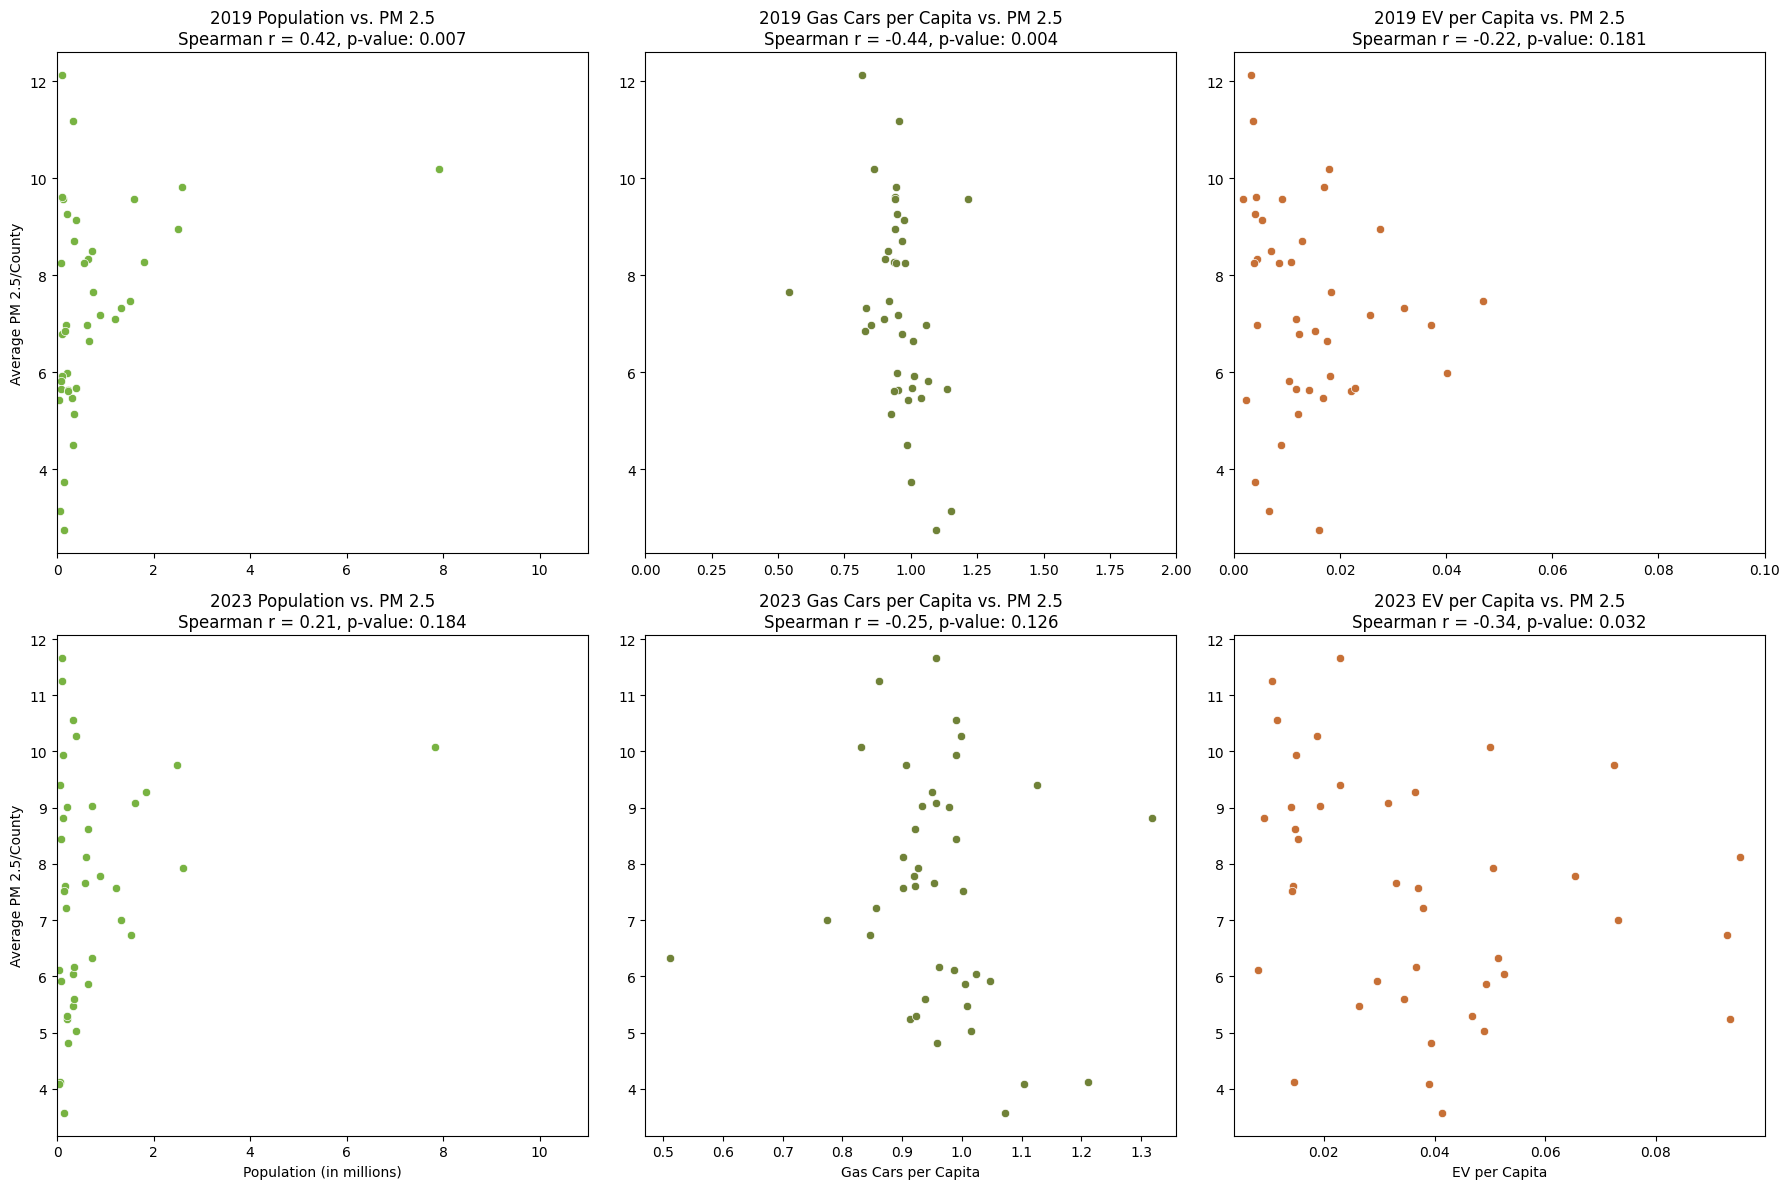

In [49]:
# Filter DataFrames for specific years
df_2023 = df_pm_vehicles_pop[df_pm_vehicles_pop['Data Year'] == 2023]
df_2019 = df_pm_vehicles_pop[df_pm_vehicles_pop['Data Year'] == 2019]

# Convert 'Adult Population' to millions
df_2023.loc[:, ['Population (M)']] = df_2023['Adult Population'] / 1_000_000
df_2019.loc[:, ['Population (M)']] = df_2019['Adult Population'] / 1_000_000

# Create subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 2019 Plots
# Calculate Spearman correlation
stat, p = spearmanr(df_2019['Population (M)'], df_2019['Average PM 2.5/County'])
print(f'Spearman correlation coefficient: {stat:.3f}, p-value: {p:.3f}')

# Plot 1 (Row 0, Col 0): Population vs. Average PM 2.5 (2019)
sns.scatterplot(x='Population (M)', y='Average PM 2.5/County', data=df_2019, ax=axes[0, 0], color='#78b342')
axes[0, 0].set_title(f'2019 Population vs. PM 2.5\nSpearman r = {stat:.2f}, p-value: {p:.3f}')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Average PM 2.5/County')
axes[0, 0].set_xlim(0, 11)

# Plot 2 (Row 0, Col 1): Gas Cars per Capita vs. Average PM 2.5 (2019)
stat, p = spearmanr(df_2019['Gas Cars per Capita'], df_2019['Average PM 2.5/County'])
print(f'Spearman correlation coefficient: {stat:.3f}, p-value: {p:.3f}')
sns.scatterplot(x='Gas Cars per Capita', y='Average PM 2.5/County', data=df_2019, ax=axes[0, 1], color='#708238')
axes[0, 1].set_title(f'2019 Gas Cars per Capita vs. PM 2.5\nSpearman r = {stat:.2f}, p-value: {p:.3f}')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlim(0, 2)

# Plot 3 (Row 0, Col 2): EV per Capita vs. Average PM 2.5 (2019)
stat, p = spearmanr(df_2019['EV per Capita'], df_2019['Average PM 2.5/County'])
print(f'Spearman correlation coefficient: {stat:.3f}, p-value: {p:.3f}')
sns.scatterplot(x='EV per Capita', y='Average PM 2.5/County', data=df_2019, ax=axes[0, 2], color='#c77036')
axes[0, 2].set_title(f'2019 EV per Capita vs. PM 2.5\nSpearman r = {stat:.2f}, p-value: {p:.3f}')
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')
axes[0, 2].set_xlim(0, 0.1)

# 2023 Plots
# Plot 4 (Row 1, Col 0): Population vs. Average PM 2.5 (2023)
stat, p = spearmanr(df_2023['Population (M)'], df_2023['Average PM 2.5/County'])
print(f'Spearman correlation coefficient: {stat:.3f}, p-value: {p:.3f}')
sns.scatterplot(x='Population (M)', y='Average PM 2.5/County', data=df_2023, ax=axes[1, 0], color='#78b342')
axes[1, 0].set_title(f'2023 Population vs. PM 2.5\nSpearman r = {stat:.2f}, p-value: {p:.3f}')
axes[1, 0].set_xlabel('Population (in millions)')
axes[1, 0].set_ylabel('Average PM 2.5/County')
axes[1, 0].set_xlim(0, 11)

# Plot 5 (Row 1, Col 1): Gas Cars per Capita vs. Average PM 2.5 (2023)
stat, p = spearmanr(df_2023['Gas Cars per Capita'], df_2023['Average PM 2.5/County'])
print(f'Spearman correlation coefficient: {stat:.3f}, p-value: {p:.3f}')
sns.scatterplot(x='Gas Cars per Capita', y='Average PM 2.5/County', data=df_2023, ax=axes[1, 1], color='#708238')
axes[1, 1].set_title(f'2023 Gas Cars per Capita vs. PM 2.5\nSpearman r = {stat:.2f}, p-value: {p:.3f}')
axes[1, 1].set_xlabel('Gas Cars per Capita')
axes[1, 1].set_ylabel('')

# Plot 6 (Row 1, Col 2): EV per Capita vs. Average PM 2.5 (2023)
stat, p = spearmanr(df_2023['EV per Capita'], df_2023['Average PM 2.5/County'])
print(f'Spearman correlation coefficient: {stat:.3f}, p-value: {p:.3f}')
sns.scatterplot(x='EV per Capita', y='Average PM 2.5/County', data=df_2023, ax=axes[1, 2], color='#c77036')
axes[1, 2].set_title(f'2023 EV per Capita vs. PM 2.5\nSpearman r = {stat:.2f}, p-value: {p:.3f}')
axes[1, 2].set_xlabel('EV per Capita')
axes[1, 2].set_ylabel('')

# Save and show the plot
plt.savefig("graphic_Correlation.png", dpi=300)

# Adjust layout
plt.tight_layout()
plt.show()

#cell formatted for PEP 8 compliance using chat-gpt 10-7-2024